In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
import re
import os
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

sys.path.append("/home/rame/domainbedv2/")
from domainbed.codeplot import plot
plot.plt.style.use('default')
sys.path.append("/data/rame/logs_experiments_notebook/")

In [2]:
plot.dict_key_to_label.update(
    {
        "pos1": "Review positivity",
        "posimdb": "lvwerra/distilbert-imdb",
        "pos": "distilbert-base-uncased-finetuned-sst-2-english",
        "toxic": "martin-ha/toxic-comment-model",
        "quality2": "valurank/distilbert-quality",
        "hfl": "OpenAssistant/reward-model-deberta-v3-large-v2",
        "hfb":  r"$HF_1$ (deberta)",
        "hfd": r"$HF_2$ (electra)",
        "hfg": "sugam11/gpt2-rlhf-reward",
        "cogd": r"$HF_2$ (bart)",
        "tristan": r"$HF_1$ (gpt2)",
    }
)
# plot.plt.rcParams["figure.figsize"] = (7, 7)
# plot.SIZE_AXIS = "small"
# plot.SIZE = "small"
plot.plt.rcParams["figure.figsize"] = (6, 6)
SIZE="large"
SIZE_AXIS="xx-large"


colormaps = [
    "Reds", "Blues", "Greens", "Oranges", "Greys", "Purples", "Reds", "Blues", "Greens", "Oranges",
    "Greys", "Purples",
"Yellows",
"Light_Yellows",
"Dark_Blues",
"Blues_Greys",
"Dark_Greys",
] * 2
do_save = True


# Llama Summary

In [3]:
from llamasummary import logs_tristan_cog_step20_v0, logs_tristan_cog_step40_kl005, logs_tristan_cog_step40, logs_tristan_cog_step30, logs_tristan_cog_step40_v0, logs_cogsoups_step40, logs_alpaca_cogsoups_step40, logs_alpaca_cog, logs_alpaca_cog_kl005, logs_tristan_cog_stepend, logs_alpaca_tristan_kl005, logs_multi_step40_200_kl005, logs_multitask_tristan_190_200, logs_multitask_cog_190_200, logs_cog_steps_200, logs_tristan_steps_200

In [4]:
modules_summary_debug = [
    logs_tristan_cog_step40_kl005, logs_tristan_cog_step40, logs_tristan_cog_stepend,
    logs_tristan_cog_step30, logs_alpaca_cog, logs_alpaca_cog_kl005, 
]
modules_summary = [
    logs_tristan_steps_200,
    logs_alpaca_tristan_kl005,
    logs_cog_steps_200,
    logs_alpaca_cog_kl005,
    logs_multi_step40_200_kl005,
    logs_tristan_cog_step40_kl005,
    logs_multitask_tristan_190_200,
    logs_multitask_cog_190_200]
modules_summary_soups = [logs_alpaca_cogsoups_step40, logs_cogsoups_step40]

In [5]:
for modules in [modules_summary, modules_summary_soups]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["tristan"] = module.d[key][0]["LABEL_0"]
                new_d["cogd"] = module.d[key][1]["FAITHFUL"] - module.d[key][1]["HALLUCINATED"]
                new_d["cogfaithful"] = module.d[key][1]["FAITHFUL"]
                module.l.append(new_d)

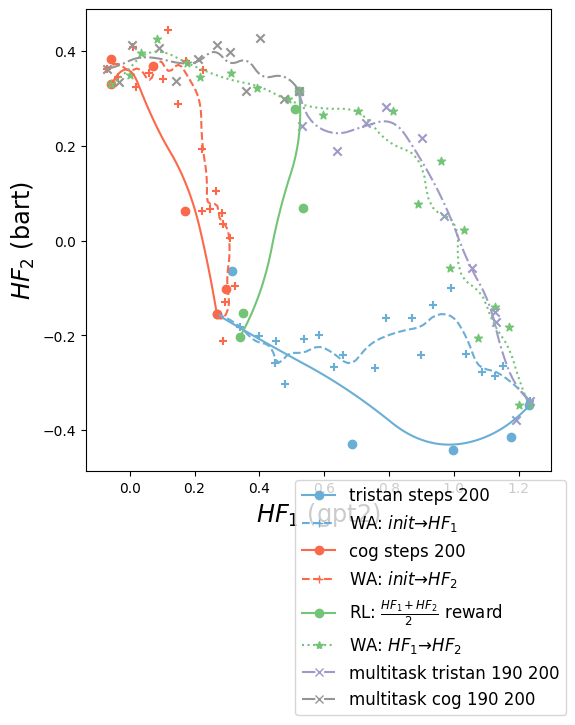

In [6]:
fig_dr = plot.plot_key(
    [module.l for module in modules_summary],
    key_y="cogd",
    key_x="tristan",
    labels=[module.label for module in modules_summary],
    loc=(1.05, 0),
    colormaps=["Blues", "Blues", "Reds", "Reds", "Greens", "Greens", "Purples", "Greys"],
    linestyles=["solid", "dashed", "solid", "dashed", "solid", "dotted", "dashdot", "dashdot"],
    connect_endpoints=False,
    order="savgol_3_1_quadratic",
)
plot.save_fig(fig=fig_dr, name="summary/pareto_summary_tristancogd.pdf", do_save=do_save)

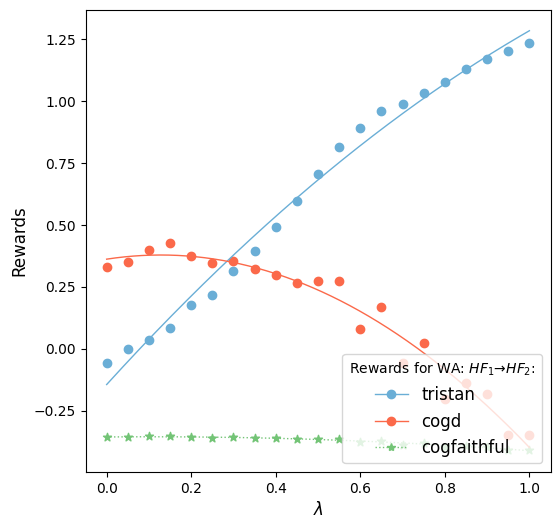

In [57]:
keys_y = ["tristan", "cogd", "cogfaithful"]

fig_dr = plot.plot_basic_scatter(
    modules_summary[5].l,
    key_x="lambda",
    keys_y=[y for i, y in enumerate(keys_y) if i in [2] or True],
    loc="lower right",
    # keycolor="abs|lambda-0.5",
    # keysize="hfl",
    colormaps=['Blues', "Reds", 'Greens', 'Purples', 'Greys'],
    linestyles=['solid', 'solid', "dotted", 'dotted', 'dotted', "dotted", "dotted", "dotted"],
    order="2",
    legendtitle=f"Rewards for {modules_summary[5].label}:",
    title=None
)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_summary_soups],
    key_x="tristan",
    key_y="cogd",
    labels=[module.label for module in modules_summary_soups],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" for i, _ in enumerate(modules_summary_soups)],
    connect_points=True,
    connect_endpoints=True,
    order=2,
)

# LLAMA Review

In [30]:
from llamareview import logs_alpaca_hfb_steps, logs_alpaca_hfb_step190, logs_hfd_steps, logs_alpaca_hfd_step190, logs_multihf, logs_hfb_hfd_step190_200, logs_multitask_hfb, logs_multitask_hfd

In [31]:
modules_hfb_hfd_200 = [
    logs_alpaca_hfb_steps,
    logs_alpaca_hfb_step190,
    logs_hfd_steps,
    logs_alpaca_hfd_step190,
    logs_multihf,
    logs_hfb_hfd_step190_200,
    logs_multitask_hfb,
    logs_multitask_hfd,    
]


In [32]:
for modules in [
    modules_hfb_hfd_200
]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["pos0"] = module.d[key][0]["POSITIVE"]
                new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
                new_d["pos1"] = module.d[key][1]["POSITIVE"]
                new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
                new_d["toxic"] = module.d[key][2]["toxic"]
                new_d["nontoxic"] = module.d[key][2]["non-toxic"] - module.d[key][2]["toxic"]
                new_d["quality"] = module.d[key][3]["good"]
                new_d["quality1"] = module.d[key][3]["medium"]
                new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
                new_d["hfl"] = module.d[key][4]["LABEL_0"]
                new_d["hfb"] = module.d[key][5]["REWARD"]
                new_d["hfd"] = module.d[key][6]["REWARD"]
                new_d["hfg"] = module.d[key][7]["LABEL_0"]
                if len(module.d[key]) >= 9:
                    new_d["toxicnew"] = module.d[key][8]["toxic"]
                module.l.append(new_d)

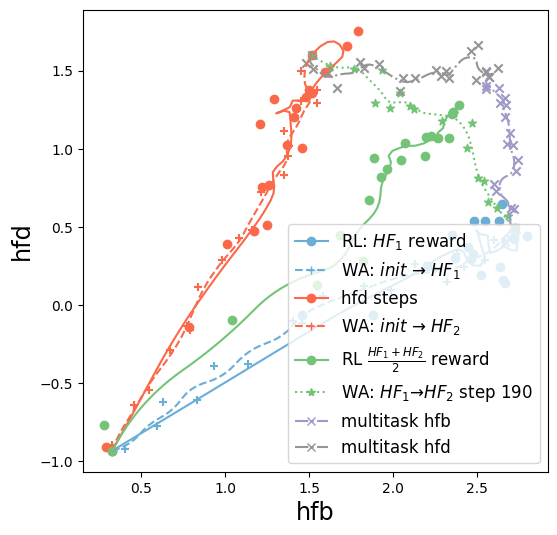

In [25]:
fig_dr = plot.plot_key(
    [module.l for module in modules_hfb_hfd_200],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules_hfb_hfd_200],
    loc="lower right",
    # keycolor="abs|lambda-0.5",
    # keysize="hfl",
    colormaps=['Blues', 'Blues', "Reds", "Reds", 'Greens', 'Greens', 'Purples', 'Greys'],
    linestyles=['solid', 'dashed', "solid", 'dashed', 'solid', "dotted", "dashdot", "dashdot"],
    order="savgol_3_1_quadratic",
    # order="connect",
    connect_endpoints=False,
)
plot.save_fig(fig=fig_dr, name="review/pareto_review_hfbhfd.pdf", do_save=do_save)

In [43]:
modules_hfb_hfd_200[6].l[0]

{'lambda': 0,
 'pos0': 1.0962342856824399,
 'posd0': 2.123539198189974,
 'pos1': 2.217570629119873,
 'posd1': 3.967211573719978,
 'toxic': -3.064314661473036,
 'nontoxic': 5.969829465448857,
 'quality': -0.6804030610062182,
 'quality1': -1.8511380358040332,
 'qualityd': -2.8281357096787545,
 'hfl': -0.7355695595429279,
 'hfb': 2.5699564151465895,
 'hfd': 1.4563738551083951,
 'hfg': -0.04818341448321007,
 'toxicnew': -6.7092313480377195}

In [47]:
modules_hfb_hfd_200[6].label

'multitask hfb'

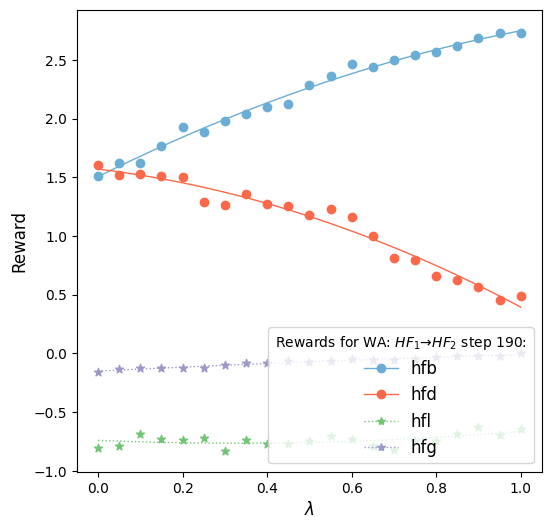

In [56]:
keys_y = ["hfb", "hfd", "hfl", "hfg"]

fig_dr = plot.plot_basic_scatter(
    modules_hfb_hfd_200[5].l,
    key_x="lambda",
    keys_y=[y for i, y in enumerate(keys_y) if i in [2] or True],
    loc="lower right",
    # keycolor="abs|lambda-0.5",
    # keysize="hfl",
    colormaps=['Blues', "Reds", 'Greens', 'Purples', 'Greys'],
    linestyles=['solid', 'solid', "dotted", 'dotted', 'dotted', "dotted", "dotted", "dotted"],
    order="2",
    legendtitle=f"Rewards for {modules_hfb_hfd_200[5].label}:",
    title=None
)

# Backup

In [ ]:
from llamahf32 import logs_hfb_hfd_step190, logs_hfb_hfd_step10, logs_hfb_hfd_step70, logs_quality2_pos_step140, logs_hfb_hfd_step120, logs_hfb_hfd_step20, logs_hfb_hfd_step170, logs_alpaca_hfb_noref_step90, logs_quality2_hfb_step10, logs_alpaca_hfd_noref_step90, logs_hfb_hfd_noref_step90, logs_quality2_pos_step60, logs_rl_merged_lora8, logs_hfb_hfd_step170_200, logs_hfb_hfd_step170_200_fixed, logs_hfb_hfd_step190_200_fixed, logs_toxic_quality_step40, logs_toxic_quality_step90_200, logs_alpaca_toxic_quality_step90_200, logs_toxic_step90, logs_pos_step90, logs_toxic_step190, logs_toxic_hfb_step190

modules = [
    logs_hfb_hfd_noref_step90, logs_alpaca_hfb_noref_step90, logs_alpaca_hfd_noref_step90,
    logs_quality2_hfb_step10
]

modules_toxic = [logs_toxic_hfb_step190, logs_toxic_step90, logs_toxic_step190]
modules_pos = [logs_pos_step90]
modules_quality2_pos = [
    logs_alpaca_toxic_quality_step90_200, logs_toxic_quality_step90_200, logs_toxic_quality_step40,
    logs_quality2_pos_step60, logs_quality2_pos_step140
]
modules_hfb_hfd = [
    logs_hfb_hfd_step10,
    logs_rl_merged_lora8,
    logs_hfb_hfd_step20,
    logs_hfb_hfd_step70,
    logs_hfb_hfd_step120,
    logs_hfb_hfd_step170,
    logs_hfb_hfd_step190,
    logs_hfb_hfd_step170_200_fixed,
    logs_hfb_hfd_step190_200_fixed,
    logs_hfb_hfd_step170_200,
]

In [ ]:
for modules in [
    modules_quality2_pos, modules_toxic, modules_pos, modules_hfb_hfd
]:
    for module in modules:
        module.l = []
        if not hasattr(module, "label"):
            module.label = " ".join(re.split('_|\.', os.path.split(module.__file__)[-1])[1:-1])
        for key in module.d.keys():
            if True:
                new_d = {"lambda": key}
                new_d["pos0"] = module.d[key][0]["POSITIVE"]
                new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
                new_d["pos1"] = module.d[key][1]["POSITIVE"]
                new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
                new_d["toxic"] = module.d[key][2]["toxic"]
                new_d["nontoxic"] = module.d[key][2]["non-toxic"] - module.d[key][2]["toxic"]
                new_d["quality"] = module.d[key][3]["good"]
                new_d["quality1"] = module.d[key][3]["medium"]
                new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
                new_d["hfl"] = module.d[key][4]["LABEL_0"]
                new_d["hfb"] = module.d[key][5]["REWARD"]
                new_d["hfd"] = module.d[key][6]["REWARD"]
                new_d["hfg"] = module.d[key][7]["LABEL_0"]
                if len(module.d[key]) >= 9:
                    new_d["toxicnew"] = module.d[key][8]["toxic"]
                module.l.append(new_d)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_hfb_hfd],
    #list_indexes = [-1],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules_hfb_hfd],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" for i, _ in enumerate(modules_hfb_hfd)],
    connect_points=True,
    connect_endpoints=False,
    order=2,
)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_pos],
    key_x="pos0",
    key_y="pos1",
    labels=[module.label for module in modules_pos],
    loc="lower left",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_pos)],
    connect_points=True,
    order=2,
)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_toxic],
    key_x="-toxic",
    key_y="hfb",
    labels=[module.label for module in modules_toxic],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_toxic)],
    connect_points=True,
    order=2,
)

In [ ]:
fig_dr = plot.plot_key(
    [module.l for module in modules_quality2_pos],
    key_x="nontoxic",
    key_y="qualityd",
    labels=[module.label for module in modules_quality2_pos],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    #keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules_quality2_pos)],
    connect_points=True,
    order=2,
)

In [ ]:
do_save = True

# LLAMA HF

In [ ]:
os.listdir("/data/rame/logs_experiments_notebook/llamahf")

In [ ]:
from llamahf import logs_rl_alpaca_hfd_hfb, logs_rl_alpaca_hfd_hfb5, logs_rl_alpaca_hfb_hfd, logs_rl_alpaca_hfb_hfd5, logs_rl_hfb_hfd, logs_rl_alpaca_hfb, logs_rl_alpaca_hfd

In [ ]:
modules = [
    logs_rl_alpaca_hfb_hfd, logs_rl_alpaca_hfb_hfd5, logs_rl_alpaca_hfd_hfb,
    logs_rl_alpaca_hfd_hfb5, logs_rl_hfb_hfd, logs_rl_alpaca_hfb, logs_rl_alpaca_hfd
]
for module in modules:
    module.l = []
    for key in module.d.keys():
        if True:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            new_d["hfl"] = module.d[key][4]["LABEL_0"]
            new_d["hfb"] = module.d[key][5]["REWARD"]
            new_d["hfd"] = module.d[key][6]["REWARD"]
            module.l.append(new_d)

In [ ]:

fig_dr = plot.plot_key(
    [module.l for module in modules],
    key_x="hfb",
    key_y="hfd",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    # keysize="hfl",
    colormaps=colormaps,
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules)],
    connect_points=True,
    order=2,
)

# LLAMA

In [ ]:
os.listdir("/data/rame/logs_experiments_notebook/llama")

In [ ]:
from llama import logs_rl_quality2_hf, logs_rl_posimdb_pos, logs_rl_hfl_quality2, logs_rl_hfl_hf, logs_rl_alpaca_posimdb, logs_rl_pos_hf, logs_rl_posimdb_quality2, logs_rl_alpaca_quality2, logs_rl_alpaca_hf, logs_rl_posimdb_hf, logs_rl_pos_quality2 

In [ ]:
modules = [
    logs_rl_alpaca_hf,
    logs_rl_alpaca_posimdb,
    logs_rl_posimdb_hf,
    # logs_rl_posimdb_pos,
    logs_rl_pos_hf,
    logs_rl_pos_quality2,
    logs_rl_quality2_hf,
    logs_rl_posimdb_quality2,
    # logs_rl_hfl_hf,
    # logs_rl_hfl_quality2
    logs_rl_alpaca_quality2,
]
for module in modules:
    module.l = []
    for key in sorted(module.d.keys()):
        if 0 <= key <= 1:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            new_d["hfl"] = module.d[key][4]["LABEL_0"]
            new_d["hfb"] = module.d[key][5]["REWARD"]
            module.l.append(new_d)

In [ ]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [module.l for module in modules],
    list_indexes=range(4),
    key_x="hfb",
    key_y="pos1",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="abs|lambda-0.5",
    # keysize="lambda",
    colormaps=[
        "Reds",
        "Purples",
        "Greys",
        "Oranges",
        "Blues",
        "Yellows",
        "Greens",
        "Reds"
    ],
    linestyles=["solid" if i % 2 else "dashed" for i, _ in enumerate(modules)],
    connect_points=True,
    order=2,
)

# NEOX

In [ ]:
sys.path.append("/data/rame/logs_experiments_notebook/")
from gptneox import logs_posimdb_negimdb, logs_quality_negimdb, logs_toxic_neg, logs_rl_pos_vs_toxic, logs_rl_posimdb_vs_toxic0, logs_rl_pos_vs_quality2, logs_rl_toxic_vs_quality1, logs_rl_toxic_vs_quality2, logs_rl_posimdb_vs_toxic, logs_rl_pos_posimdb

In [ ]:
modules = [
    logs_posimdb_negimdb, logs_quality_negimdb, logs_rl_pos_vs_quality2, logs_rl_pos_posimdb,
    # logs_toxic_neg,
    # logs_rl_pos_vs_toxic,
    # logs_rl_posimdb_vs_toxic0,
    # logs_rl_toxic_vs_quality1,
    # logs_rl_toxic_vs_quality2,
    # logs_rl_posimdb_vs_toxic,
]
for module in modules:
    module.l = []
    for key in sorted(module.d.keys()):
        if 0 <= key <= 1:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            module.l.append(new_d)

In [ ]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [module.l for module in modules],
    key_x="posd0",
    key_y="quality",
    labels=[module.label for module in modules],
    loc="lower left",
    # keycolor="lambda",
    # colormaps=[
    #     "Reds",
    #     "Purples",
    #     "Oranges",
    #     "Greys",
    #     "Blues",
    #     "Yellows",
    #     "Greens",
    # ],
    linestyles=["solid" for module in modules],
    # linestyles=[ls if ls not in [] else None for ls in [
    #     "solid",
    #     "dashed",
    #     "solid",
    #     "solid",
    # ]],
    connect_points=True,
    order=2,
)